In [2]:
import os
import re
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ks_2samp

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.1.final.0
python-bits      : 64
OS               : Windows
OS-release       : 7
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 39.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.10.2
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3

In [3]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [4]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3

In [5]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

# Add labels to train data

In [ ]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [ ]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

# Extract event data JSON

In [ ]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols]
        chunk = _concat_columns(chunk, ed)
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    assert len(df) == len(res)
    return res


#keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses',
#            'ed.weight', 'ed.total_duration', 'ed.source']
#train_raw = _extract_event_data(train_raw, keep_cols)
#test_raw = _extract_event_data(test_raw, keep_cols)

In [ ]:
test_raw.info(max_cols=999)

In [ ]:
train_raw.info(max_cols=999)

In [ ]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

In [ ]:
EVENT_IDS = sorted(list(set(train_raw['event_id']) | set(test_raw['event_id'])))
_log(f'{len(EVENT_IDS)} EVENT_IDS={EVENT_IDS}')

In [ ]:
TITLES = test_raw['title'].unique()
test_raw['title'].value_counts()

In [ ]:
TYPES = test_raw['type'].unique()
test_raw['type'].value_counts()

In [ ]:
WORLDS = test_raw['world'].unique()
test_raw['world'].value_counts()

In [ ]:
#test_raw['ed.source'].value_counts()

In [ ]:
#test_raw['ed.identifier'].value_counts()

In [ ]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

In [ ]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [ ]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp', 'ed.identifier', 'ed.source']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

In [ ]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [ ]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

# Train-test split not by time
Both train and test sets span the same time period.

In [ ]:
_log(f'train_raw[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test_raw[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

In [ ]:
train_raw.info()

# Feature Engineering

In [ ]:
def _key(s):
    return re.sub(r'[\W\s]', '', s).lower()


def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_session_stats(df, col, suffix, denominators={}):
    res = {}
    groups = [
        ['game_session'],
        ['game_session', 'type'],
        ['game_session', 'world'],
        ['game_session', 'title']
    ]
    for g in groups:
        vs = df.groupby(g)[col].transform('max')
        qs = vs.quantile([0.25, 0.5, 0.75], interpolation='lower').to_numpy()
        g_key = _key(''.join(g))
        k = f'{col}_p50_{g_key}{suffix}'
        res[k] = np.int32([qs[1]])
        if k in denominators:
            ratio_key = f'{col}_p50_{g_key}_ratio{suffix}'
            res[ratio_key] = np.float32([res[k][0] / denominators[k][0]])
        #res[f'{col}_max_{k}{suffix}'] = np.int32([vs.max()])
        #res[f'{col}_std_{k}{suffix}'] = np.float32([vs.std(ddof=0)])
        #res[f'{col}_iqr_{k}{suffix}'] = np.int32([qs[2] - qs[0]])
    return res


def _event_id_features(df, EVENT_IDS, TITLES, TYPES, WORLDS, suffix):
    res = {}
    # initialize counts
    for eid in EVENT_IDS:
        res[f'eid_{eid}{suffix}'] = np.int32([0])      
        for t in TYPES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
        
        for t in WORLDS:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in TITLES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
                      
    tmp = df.groupby(['event_id'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'eid_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(TYPES) != 0:
        tmp = df.groupby(['event_id', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(WORLDS) != 0:
        tmp = df.groupby(['event_id', 'world'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(TITLES) != 0:
        tmp = df.groupby(['event_id', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])
        
    return res


def _event_code_features(df, EVENT_CODES, TITLES, TYPES, WORLDS, suffix):
    res = {}
    for code in EVENT_CODES:
        res[f'event_{code}{suffix}'] = np.int32([0])      
        for t in TYPES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
        for t in WORLDS:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in TITLES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
    tmp = df.groupby(['event_code'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'event_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(TYPES) != 0:
        tmp = df.groupby(['event_code', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(WORLDS) != 0:
        tmp = df.groupby(['event_code', 'world'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(TITLES) != 0:
        tmp = df.groupby(['event_code', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])
        
    return res


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    res[f'ed_source_resources{suffix}'] = np.int32([sum(df['ed.source'] == 'resources')])
    res[f'ed_source_right{suffix}'] = np.int32([sum(df['ed.source'] == 'right')])
    res[f'ed_source_left{suffix}'] = np.int32([sum(df['ed.source'] == 'left')])
    res[f'ed_source_scale{suffix}'] = np.int32([sum(df['ed.source'] == 'scale')])
    res[f'ed_source_middle{suffix}'] = np.int32([sum(df['ed.source'] == 'middle')])
    res[f'ed_source_heaviest{suffix}'] = np.int32([sum(df['ed.source'] == 'Heaviest')])
    res[f'ed_source_heavy{suffix}'] = np.int32([sum(df['ed.source'] == 'Heavy')])
    res[f'ed_source_lightest{suffix}'] = np.int32([sum(df['ed.source'] == 'Lightest')])
    n = 0
    for i in range(1, 13):
        n += sum(df['ed.source'] == str(i))
    res[f'ed_source_numbered{suffix}'] = np.int32([n])
    res[f'ed_id_dot{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Dot_', regex=False))])
    res[f'ed_id_buddy{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Buddy_', regex=False))])
    res[f'ed_id_cleo{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Cleo_', regex=False))])
    res[f'ed_id_mom{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Mom_', regex=False))])
    res[f'ed_id_sid{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('sid_', regex=False))])
    positives = {'Dot_SoCool', 'Dot_GreatJob', 'ohWow', 'wowSoCool', 'thatLooksSoCool', 'tub_success', 
                 'water_success', 'soap_success', 'Dot_Amazing', 'Dot_WhoaSoCool', 'Dot_ThatsIt', 'youDidIt_1305',
                 'SFX_completedtask', 'Cleo_AmazingPowers', 'RIGHTANSWER1', 'Dot_Awesome', 'greatJob_1306', 'YouDidIt',
                 'RIGHTANSWER3', 'RIGHTANSWER2', 'INSTRCOMPLETE', 'AWESOME', 'WayToGoTeam', 'Dot_NiceWorkAllMatch',
                 'GreatFlying', 'WeDidItOneRoundLeft', 'Cleo_AweOfYourSkills', 'Dot_NiceWork'}
    n_pos = 0
    for p in positives:
        n_pos += sum(df['ed.identifier'].str.contains(p, regex=False))
    res[f'ed_id_positive{suffix}'] = np.int32([n_pos])
    negatives = {'Dot_Uhoh', 'Dot_UhOh', 'Dot_NeedTryAgain', 'IncorrectTooHeavy', 'Dot_GoLower', 'Buddy_TryDifferentNest',
                 'Cleo_BowlTooLight', 'Dot_GoHigher', 'Dot_SoLow', 'Dot_SoHigh', 'Dot_WhoopsTooShort', 'IncorrectTooLight',
                 'NOT_THAT_HEAVY', 'Dot_UhOhTooTall', 'ADD_MORE_WEIGHT', 'wrong1', 'tryAgain1', 'Dot_TryWeighingAgain',
                 'Cleo_RememberHeavierBowl', 'Dot_Whoops', 'Dot_NotBalanced', 'Mom_TooManyContainers',
                 'WrongOver', 'Mom_TooMuchWater', 'Dot_ThatBucketNotRight', 'Dot_TryAgain', 'wrongFewer', 'WrongBetweenCliff',
                 'Mom_NeedMoreContainers', 'Dot_Try', 'Dot_HmTooSmall'}
    n_neg = 1
    for ne in negatives:
        n_neg += sum(df['ed.identifier'].str.contains(ne, regex=False))
    res[f'ed_id_negative{suffix}'] = np.int32([n_neg])
    res[f'ed_id_positive_ratio{suffix}'] = np.float32([n_pos / n_neg])
    return res
    

def _features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators, suffix=''):
    res = {}
    for t in TYPES:
        res[f'type_{_key(t)}{suffix}'] = np.int32([sum(df['type'] == t)])
    
    for t in WORLDS:
        res[f'world_{_key(t)}{suffix}'] = np.int32([sum(df['world'] == t)])
    
    for t in TITLES:
        res[f'title_{_key(t)}{suffix}'] = np.int32([sum(df['title'] == t)])
    
    cols = ['game_time', 'event_count']
    for col in cols:
        res.update(_game_session_stats(df, col, suffix, denominators=denominators))
    
    res.update(_event_code_features(df, EVENT_CODES, TITLES=TITLES, TYPES=TYPES, WORLDS=WORLDS, suffix=suffix))
    res.update(_event_id_features(df, EVENT_IDS, TITLES=TITLES, TYPES=TYPES, WORLDS=WORLDS, suffix=suffix))
    #res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators):
    res = {}
    iid = df[df['installation_id'] == installation_id].copy()
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]    
    res.update(_features_map(iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    prev_len = None
    for iid in tqdm(iids):
        tmp = _features(raw, iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)
        prev_len = len(tmp.columns) if prev_len is None else prev_len
        assert len(tmp.columns) == prev_len
        prev_len = len(tmp.columns)
        res = pd.concat([res, tmp], ignore_index=True)
    return res


denominators = {}
cols = ['game_time', 'event_count']
for col in cols:
    denominators.update(_game_session_stats(train_raw, col, suffix=''))
_log(f'ratio denominators={denominators}')

In [ ]:
# budget of 5 seconds per iteration
train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)

In [ ]:
train.info(max_cols=9999)

In [ ]:
assert train.notna().all(axis=None)
train.head(10)

In [ ]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)

In [ ]:
test.info(max_cols=9999)

In [ ]:
assert test.notna().all(axis=None)
test.head(20)

In [ ]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

# Train Model
Approach: Stacking two models
1. Binary classification - was the assessment solved or not?
1. Regression on the number of attempts taken to solve the assessment

Reason: `accuracy_group` labels '1', '2' and '3' are ordinal but not '0'. See https://www.kaggle.com/c/data-science-bowl-2019/discussion/124836

In [ ]:
%%time
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [ ]:
def _log_transform(df, cols):
    df[cols] = np.float32(np.log(df[cols] + 1))


#cols = list(set(test.columns.values) - {'installation_id'})
#_log_transform(train, cols)
#_log_transform(test, cols)
#train.head()

In [ ]:
%%time
def _scaling(dfs, cols, scaler=None):
    scaler = sklearn.preprocessing.RobustScaler() if scaler is None else scaler
    scaler.fit(dfs[0][cols])
    for df in dfs:
        df[cols] = np.float32(scaler.transform(df[cols]))
        assert df.notna().all(axis=None)


#scaler = sklearn.preprocessing.PowerTransformer()
cols = list(set(test.columns.values) - {'installation_id'})
_scaling([train, test], cols)
train.head()

In [ ]:
train.to_parquet('train_scaled.parquet')
test.to_parquet('test_scaled.parquet')
_log(os.listdir("."))

# Feature selection
[KS Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

In [7]:
%%time
train = pd.read_parquet('train_scaled.parquet')
test = pd.read_parquet('test_scaled.parquet')

Wall time: 55.9 s


In [8]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = float('1e-02')
features = set(test.columns.values) - {'installation_id'}
PREDICTORS = _select_features(train, test, features, ALPHA)

100%|███████████████████████████████████████████| 22381/22381 [02:22<00:00, 156.58it/s]


In [9]:
dropped = sorted(list(features - set(PREDICTORS)))
PREDICTORS = sorted(PREDICTORS)
_log(f'alpha={ALPHA}, keep {len(PREDICTORS)}/{len(features)} features, drop {len(dropped)} features.\nkeep={PREDICTORS}')

alpha=0.01, keep 20493/22381 features, drop 1888 features.
keep=['eid_0086365d_12monkeys', 'eid_0086365d_activity', 'eid_0086365d_airshow', 'eid_0086365d_allstarsorting', 'eid_0086365d_assessment', 'eid_0086365d_balancingact', 'eid_0086365d_birdmeasurerassessment', 'eid_0086365d_bottlefilleractivity', 'eid_0086365d_bubblebath', 'eid_0086365d_bugmeasureractivity', 'eid_0086365d_cartbalancerassessment', 'eid_0086365d_cauldronfillerassessment', 'eid_0086365d_chestsorterassessment', 'eid_0086365d_chickenbalanceractivity', 'eid_0086365d_chowtime', 'eid_0086365d_clip', 'eid_0086365d_costumebox', 'eid_0086365d_crystalcaveslevel1', 'eid_0086365d_crystalcaveslevel2', 'eid_0086365d_crystalcaveslevel3', 'eid_0086365d_crystalsrule', 'eid_0086365d_dinodive', 'eid_0086365d_dinodrink', 'eid_0086365d_eggdropperactivity', 'eid_0086365d_fireworksactivity', 'eid_0086365d_flowerwatereractivity', 'eid_0086365d_happycamel', 'eid_0086365d_heavyheavierheaviest', 'eid_0086365d_honeycake', 'eid_0086365d_leaflea

In [10]:
_log(f'drop={dropped}')

drop=['eid_0086365d', 'eid_0086365d_crystalcaves', 'eid_0086365d_game', 'eid_0086365d_panbalance', 'eid_00c73085', 'eid_00c73085_dinodive', 'eid_00c73085_game', 'eid_00c73085_magmapeak', 'eid_022b4259', 'eid_022b4259_activity', 'eid_022b4259_bugmeasureractivity', 'eid_022b4259_treetopcity', 'eid_02a42007', 'eid_02a42007_activity', 'eid_02a42007_fireworksactivity', 'eid_02a42007_treetopcity', 'eid_0330ab6a', 'eid_0330ab6a_chowtime', 'eid_0330ab6a_crystalcaves', 'eid_0330ab6a_game', 'eid_0413e89d', 'eid_0413e89d_bubblebath', 'eid_0413e89d_game', 'eid_0413e89d_magmapeak', 'eid_04df9b66', 'eid_04df9b66_assessment', 'eid_04df9b66_cauldronfillerassessment', 'eid_04df9b66_magmapeak', 'eid_06372577', 'eid_06372577_airshow', 'eid_06372577_game', 'eid_06372577_treetopcity', 'eid_070a5291', 'eid_070a5291_assessment', 'eid_070a5291_birdmeasurerassessment', 'eid_070a5291_treetopcity', 'eid_08fd73f3', 'eid_08fd73f3_game', 'eid_08fd73f3_magmapeak', 'eid_08fd73f3_scrubadub', 'eid_0a08139c', 'eid_0a081

In [11]:
train['is_solved'] = -1
train['solved_attempts'] = -1
train.loc[train[TARGET] == 0, ['is_solved']] = 0
train.loc[train[TARGET] != 0, ['is_solved']] = 1
train.loc[train[TARGET] == 3, ['solved_attempts']] = 1
train.loc[train[TARGET] == 2, ['solved_attempts']] = 2
train.loc[train[TARGET] == 1, ['solved_attempts']] = 3

# Classify whether assessment was solved or not

In [12]:
%%time
y_train_cls = train['is_solved']
x_train_cls = train[PREDICTORS]
model = lgb.LGBMClassifier(n_estimators=10000, reg_alpha=1, objective='binary')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__num_leaves': [8],
    'model__min_child_samples': [40],
    'model__colsample_bytree': [0.01]
}
cls = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring='f1')
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cls.fit(x_train_cls, y_train_cls)
assert cls.best_estimator_['model'].n_classes_ == 2
_log(f"""F1 LGBMClassifier
best_score_={cls.best_score_:.5f}
best_params_={cls.best_params_}
n_features={cls.best_estimator_['model'].n_features_}
""")

F1 LGBMClassifier
best_score_=0.83571
best_params_={'model__colsample_bytree': 0.01, 'model__learning_rate': 0.001, 'model__min_child_samples': 40, 'model__num_leaves': 8}
n_features=20493

Wall time: 1min 36s


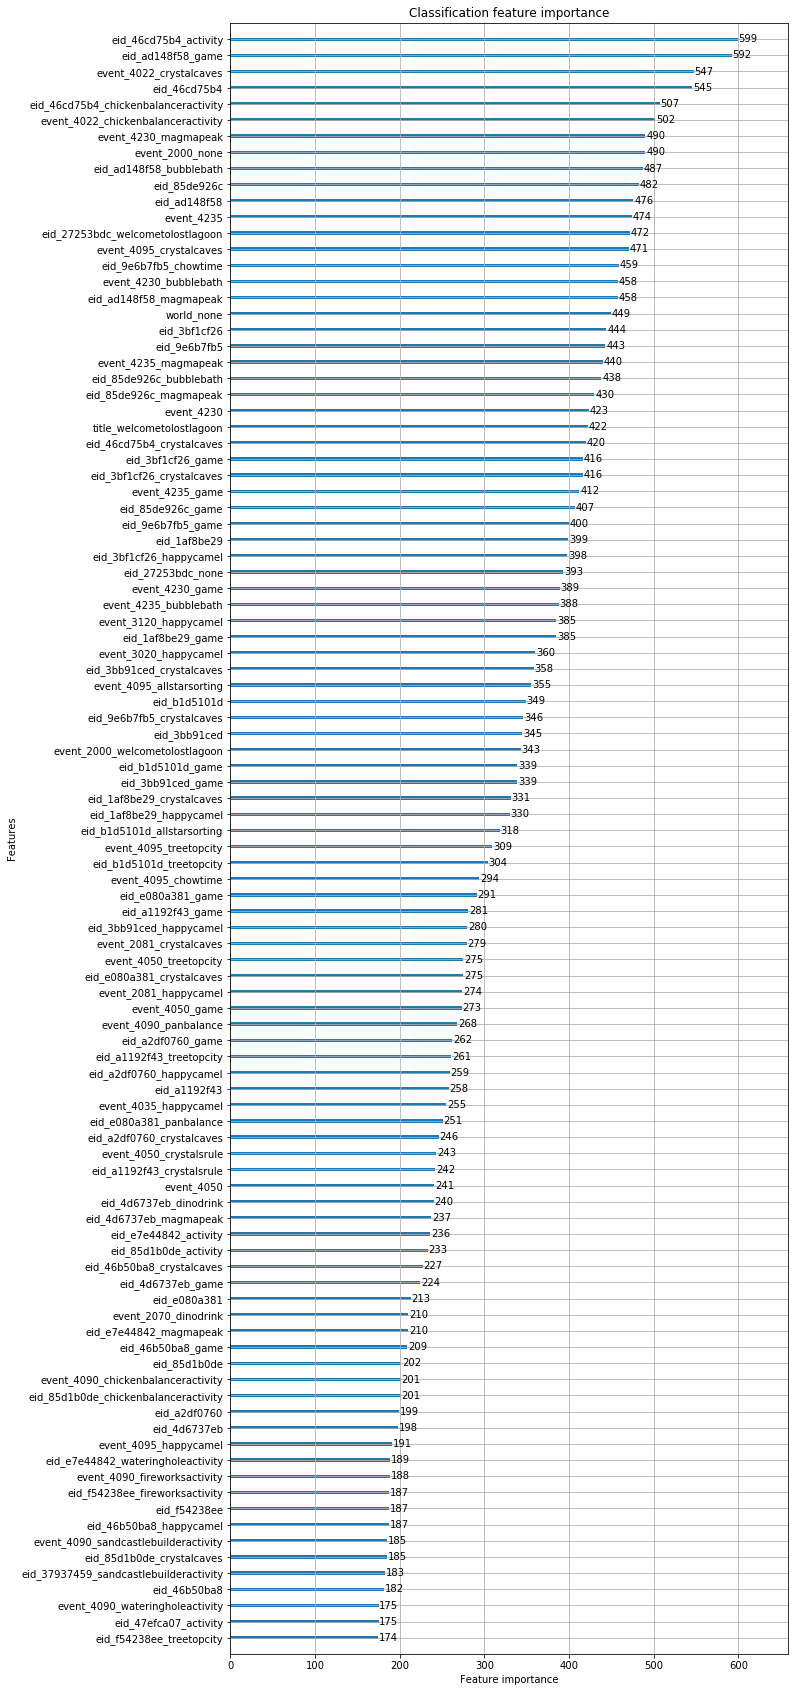

In [13]:
lgb.plot_importance(cls.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Classification feature importance')

In [14]:
%%time
model = RandomForestClassifier(n_estimators=4000, max_features='log2')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__max_depth': [4],
    'model__min_samples_leaf': [40]
}
rfc = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring='f1')
rfc.fit(x_train_cls, y_train_cls)
assert rfc.best_estimator_['model'].n_classes_ == 2
_log(f"""F1 RandomForestClassifier
best_score_={rfc.best_score_:.5f}
best_params_={rfc.best_params_}
n_features={rfc.best_estimator_['model'].n_features_}
""")

F1 RandomForestClassifier
best_score_=0.83513
best_params_={'model__max_depth': 4, 'model__min_samples_leaf': 40}
n_features=20493

Wall time: 39.3 s


# Regression on the number of attempts to solve the assessment

In [15]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [16]:
%%time
tmp = train[train['is_solved'] == 1]
y_train = tmp['solved_attempts']
x_train = tmp[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=10000, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__num_leaves': [16],
    'model__min_child_samples': [40],
    'model__colsample_bytree': [0.01]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
_log(f"""RMSE LGBMRegressor
best_score_={cv.best_score_:.5f}
best_params_={cv.best_params_}
n_features={cv.best_estimator_['model'].n_features_}
""")

RMSE LGBMRegressor
best_score_=-0.78877
best_params_={'model__colsample_bytree': 0.01, 'model__learning_rate': 0.001, 'model__min_child_samples': 40, 'model__num_leaves': 16}
n_features=20493

Wall time: 1min 30s


In [17]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

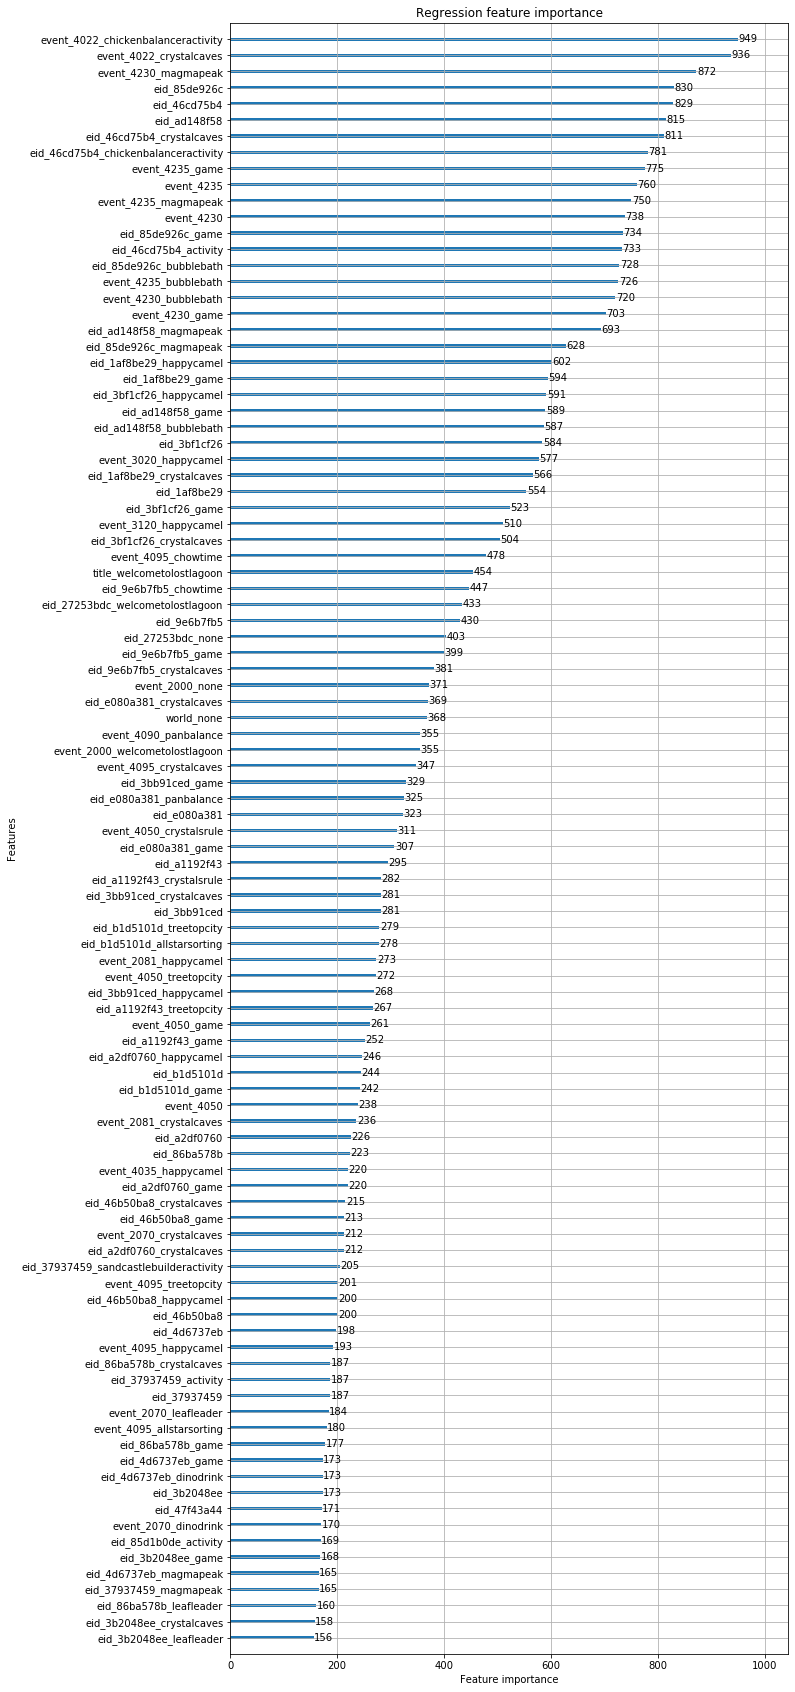

In [18]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Regression feature importance')

In [19]:
%%time
model = RandomForestRegressor(n_estimators=4000, max_features='log2')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__max_depth': [4],
    'model__min_samples_leaf': [40]
}
rfr = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
rfr.fit(x_train, y_train)
_log(f"""RMSE RandomForestRegressor
best_score_={rfr.best_score_:.5f}
best_params_={rfr.best_params_}
n_features={rfr.best_estimator_['model'].n_features_}
""")

RMSE RandomForestRegressor
best_score_=-0.79208
best_params_={'model__max_depth': 4, 'model__min_samples_leaf': 40}
n_features=20493

Wall time: 28.7 s


# Predict out of fold

In [27]:
%%time




def _predict(df, classifiers, regressors):
    res = df[['installation_id']].copy()
    res[TARGET] = np.nan
    x_cls = df[PREDICTORS]
    res['is_solved'] = 0
    for c, w, name in classifiers:
        col = f'is_solved_{name}'
        res[col] = c.predict_proba(x_cls)[:,1]
        res['is_solved'] += res[col] * w
    
    res['is_solved'] = np.int16(np.round(res['is_solved']))
    iids = set(res[res['is_solved'] == 1]['installation_id'].values)
    cols = ['installation_id'] + PREDICTORS
    tmp = df[df['installation_id'].isin(iids)][cols].copy()
    x = tmp[PREDICTORS]
    cols = ['installation_id', 'solved_attempts']
    tmp['solved_attempts'] = 0
    for r, w, name in regressors:
        col = f'solved_attempts_{name}'
        cols.append(col)
        tmp[col] = r.predict(x)
        tmp['solved_attempts'] += tmp[col] * w
        
    tmp['solved_attempts'] = np.int16(np.round(tmp['solved_attempts']))
    tmp = tmp[cols]
    res = res.merge(tmp, on='installation_id', how='left')
    res.loc[res['is_solved'] == 0, [TARGET]] = 0
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] >= 3), [TARGET]] = 1
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] == 2), [TARGET]] = 2
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] <= 1), [TARGET]] = 3
    assert res[TARGET].notna().all(axis=None)
    res[TARGET] = np.int16(res[TARGET])
    return res


classifiers=[
    (cls, 0.6, 'LGBMClassifier'),
    (rfc, 0.4, 'RandomForestClassifier')
]
regressors=[
    (cv, 0.6, 'LGBMRegressor'), 
    (rfr, 0.4, 'RandomForestRegressor')
]
oof = _predict(train, classifiers=classifiers, regressors=regressors)
oof.head(10)

Wall time: 32.4 s


,installation_id,accuracy_group,is_solved,is_solved_LGBMClassifier,is_solved_RandomForestClassifier,solved_attempts,solved_attempts_LGBMRegressor,solved_attempts_RandomForestRegressor
0,0006a69f,2,1,0.677810,0.708268,2.0,1.559929,1.560717
1,0006c192,2,1,0.776005,0.722149,2.0,1.587989,1.564114
2,00129856,2,1,0.721076,0.717166,2.0,1.539267,1.555129
3,001d0ed0,2,1,0.688629,0.714600,2.0,1.495496,1.559465
4,00225f67,2,1,0.717459,0.718003,2.0,1.651877,1.563086
5,00279ac5,2,1,0.643689,0.706776,2.0,1.800104,1.572125
6,002db7e3,2,1,0.761944,0.716428,2.0,1.779747,1.574432
7,003372b0,3,1,0.821946,0.731214,1.0,1.344419,1.555209
8,004c2091,2,1,0.721076,0.717166,2.0,1.539267,1.555129
9,00634433,2,1,0.711100,0.716799,2.0,1.538472,1.555162


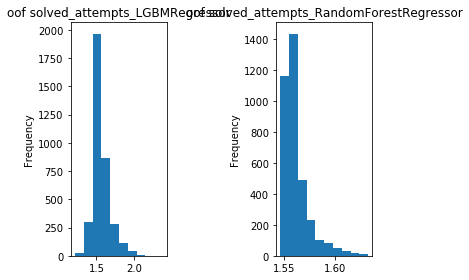

In [21]:
plt.subplot(1, 2, 1)
plt.title('oof solved_attempts_LGBMRegressor')
oof['solved_attempts_LGBMRegressor'].plot(kind='hist')
plt.subplot(1, 2, 2)
plt.title('oof solved_attempts_RandomForestRegressor')
oof['solved_attempts_RandomForestRegressor'].plot(kind='hist')
plt.tight_layout()

In [22]:
oof = oof.sort_values(by=['installation_id'])
train = train.sort_values(by=['installation_id'])
score = cohen_kappa_score(oof[TARGET], train[TARGET], weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.05398


# Predict on Test set

In [23]:
%%time
sub = _predict(test, classifiers=classifiers, regressors=regressors)
sub = sub[['installation_id', TARGET]]
sub.head()

Wall time: 24.7 s


,installation_id,accuracy_group
0,00abaee7,2
1,01242218,2
2,017c5718,2
3,01a44906,2
4,01bc6cb6,3


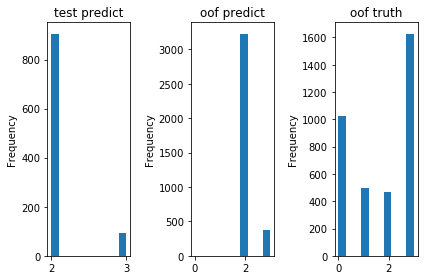

In [24]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [25]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']
